In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from DataHelper import *
import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [3]:
DATA_PATH = './data'
QUOTATIONS = ['AMZN', 'GOOG', 'AAPL', 'GM', 'TSLA', 'JNJ', 'XOM', 'AAL', 'KO', 'WMT']
FILE_SUFFIX = '.txt'
price_column = 'Close'

df = None
predict_n = 5

for quot in QUOTATIONS:
    #temp_df = pipeline_preprocessing(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n, price_column=price_column)
    temp_df, feature_names = features_pipeline(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n,
                                price_column=price_column, normalize_features=True, 
                                base_features_normalize=['tc'])
    if df is None:
        df = temp_df
    else:
        df = df.append(temp_df)

print(len(df))
df.head()
df = df.dropna()

32874


In [4]:
df.isna().any()

Date              False
Open              False
High              False
Low               False
Close             False
Volume            False
Adjusted          False
Difference        False
PercentageDiff    False
Tendency          False
MA(10)            False
MA_diff           False
RSI(14)           False
GAP               False
RSI_diff          False
Volume_diff       False
Next              False
dtype: bool

In [5]:
from torch.utils.data import Dataset

class StocksDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.Tensor(data.values)
        self.target = torch.Tensor(target.values)
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
        
    def __len__(self):
        return len(self.data)

y_column = 'Next'
data_columns = ['Close', 'Volume'] + feature_names


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})
    

    
X = dataset.loc[:, dataset.columns != y_column]
Y = dataset[y_column]

#print(X.head())

train_dataset = StocksDataset(X,Y)
print(Y.head())
X.head()

24    1
25    1
26    1
27    1
28    1
Name: Next, dtype: int64


,Close,Volume,Difference,PercentageDiff,Tendency,MA(10),MA_diff,RSI(14),GAP,RSI_diff,Volume_diff
24,38.270000,8612700.0,0.492814,0.320156,1,0.000249,0.551516,0.234965,0.562029,0.390673,0.335527
25,38.980000,10503200.0,0.493479,0.339942,1,0.000217,0.551645,0.200288,0.560717,0.394841,0.359714
26,39.099998,5483600.0,0.493424,0.338188,1,0.000186,0.551613,0.169028,0.560483,0.398259,0.322489
27,38.720001,5960100.0,0.492495,0.310918,1,0.000190,0.551247,0.139168,0.560717,0.387374,0.329798
28,38.849998,3835700.0,0.493368,0.336788,1,0.000232,0.550571,0.156536,0.560104,0.415224,0.312113


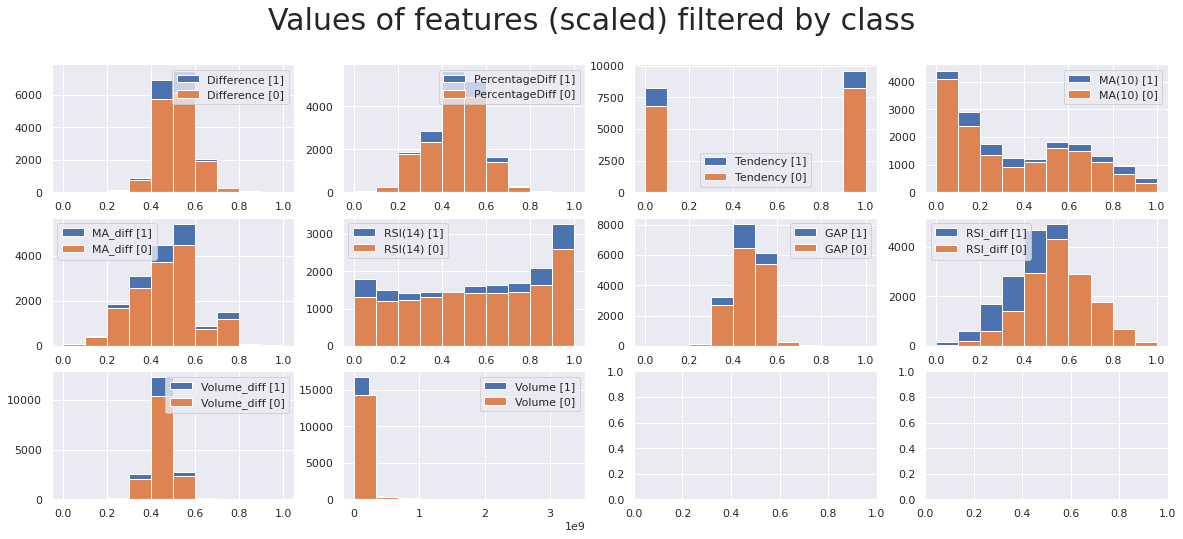

In [23]:
N_COLS = 4
plot_feature_names = feature_names.copy()

if 'Next' in plot_feature_names:
    plot_feature_names.remove('Next')
if 'Volume' in dataset.columns.values:
    plot_feature_names.append('Volume')

# get an array of subplots depending on the number of features, splitted into 3 columns
fig, axs = plt.subplots(int(np.ceil(len(plot_feature_names) / N_COLS)), N_COLS)
fig.suptitle('Values of features (scaled) filtered by class')
for i, feature in enumerate(plot_feature_names):
    sub_df = dataset[[feature, 'Next']]
    #print(f"[{i}] : {i // N_COLS}, {i % N_COLS}")
    for target_c in Y.value_counts().to_dict().keys():
        filtered_df = sub_df[sub_df['Next'] == target_c]
        axs[i // N_COLS, i % N_COLS].hist(sub_df[sub_df['Next'] == target_c][feature], label=f"{feature} [{target_c}]")
        axs[i // N_COLS, i % N_COLS].legend(loc='best')


plt.show()

In [15]:
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

### Model

In [16]:
import torch.nn as nn

class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
            #nn.Softmax(1),
        )
        
        
    def forward(self, x):
        out = self.classifier(x)
        #print(out)
        return out
    
import DL_utils
import importlib
importlib.reload(DL_utils)
from DL_utils import train

def create_model(lr, input_dim):
    model = LinearModel(input_dim=input_dim)
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    return model, optimizer, loss_fn

lr = 1e-5

model, optimizer, loss_fn = create_model(lr, input_dim = len(X.columns))
model = model.to(device)
train(dataloader, model, n_epochs=50, optimizer=optimizer, loss_fn=loss_fn, device=device)

Epoch 1, loss: 0.6721752285957336, accuracy : 53.70
Epoch 2, loss: 0.6667634844779968, accuracy : 54.28
Epoch 3, loss: 0.7071784138679504, accuracy : 54.22
Epoch 4, loss: 0.7160720229148865, accuracy : 54.22
Epoch 5, loss: 0.6948268413543701, accuracy : 54.25
Epoch 6, loss: 0.7613839507102966, accuracy : 54.23
Epoch 7, loss: 0.6942242980003357, accuracy : 54.28
Epoch 8, loss: 0.697424590587616, accuracy : 54.25
Epoch 9, loss: 0.6754658818244934, accuracy : 54.29
Epoch 10, loss: 0.6944205164909363, accuracy : 54.27
Epoch 11, loss: 0.7293509840965271, accuracy : 54.25
Epoch 12, loss: 0.6848630905151367, accuracy : 54.27
Epoch 13, loss: 0.7235409617424011, accuracy : 54.27
Epoch 14, loss: 0.6986193060874939, accuracy : 54.27
Epoch 15, loss: 0.7497913837432861, accuracy : 54.20
Epoch 16, loss: 0.6975310444831848, accuracy : 54.27
Epoch 17, loss: 0.7271150946617126, accuracy : 54.21
Epoch 18, loss: 0.687431275844574, accuracy : 54.27
Epoch 19, loss: 0.6655637621879578, accuracy : 54.27
Epoc

KeyboardInterrupt: 